In [ ]:
import torchvision
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from torchvision import transforms
mnist = torchvision.datasets.MNIST(root='.', download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 122894167.23it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 19569578.97it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 38123829.40it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15071620.86it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
def continue_training():
    network.train()
    for i in range(10):
        correct = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = network(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    score = float(correct/len(train_loader.dataset))
    accuracy_train.append(score)
    print('Iteration', len(accuracy_train), 'Training accuracy:', score)

    correct = 0
    network.eval()
    for data, target in test_loader:
        output = network(data)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    score = float(correct/len(test_loader.dataset))
    accuracy_test.append(score)
    print('Iteration', len(accuracy_test), 'Testing accuracy:', score)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, l1_reg=0, l2_reg=0):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5)
        self.conv2 = nn.Conv2d(12, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        if self.l1_reg:
            l1_loss = 0
            for param in self.parameters():
                l1_loss += torch.norm(param, 1)
            l1_loss *= self.l1_reg
            x += l1_loss

        if self.l2_reg:
            l2_loss = 0
            for param in self.parameters():
                l2_loss += torch.norm(param, 2)
            l2_loss *= self.l2_reg
            x += l2_loss

        return F.log_softmax(x, dim=1)


Iteration 1 Training accuracy: 0.7135999798774719
Iteration 1 Testing accuracy: 0.8356000185012817
Iteration 2 Training accuracy: 0.9444000124931335
Iteration 2 Testing accuracy: 0.9272000193595886
Iteration 3 Training accuracy: 0.9643999934196472
Iteration 3 Testing accuracy: 0.9430000185966492
Iteration 4 Training accuracy: 0.9761999845504761
Iteration 4 Testing accuracy: 0.9520000219345093
Iteration 5 Training accuracy: 0.982200026512146
Iteration 5 Testing accuracy: 0.9545999765396118
Iteration 1 Training accuracy: 0.5658000111579895
Iteration 1 Testing accuracy: 0.47940000891685486
Iteration 2 Training accuracy: 0.925000011920929
Iteration 2 Testing accuracy: 0.9160000085830688
Iteration 3 Training accuracy: 0.9557999968528748
Iteration 3 Testing accuracy: 0.9386000037193298
Iteration 4 Training accuracy: 0.9678000211715698
Iteration 4 Testing accuracy: 0.9417999982833862
Iteration 5 Training accuracy: 0.9771999716758728
Iteration 5 Testing accuracy: 0.9535999894142151
Iteration 1

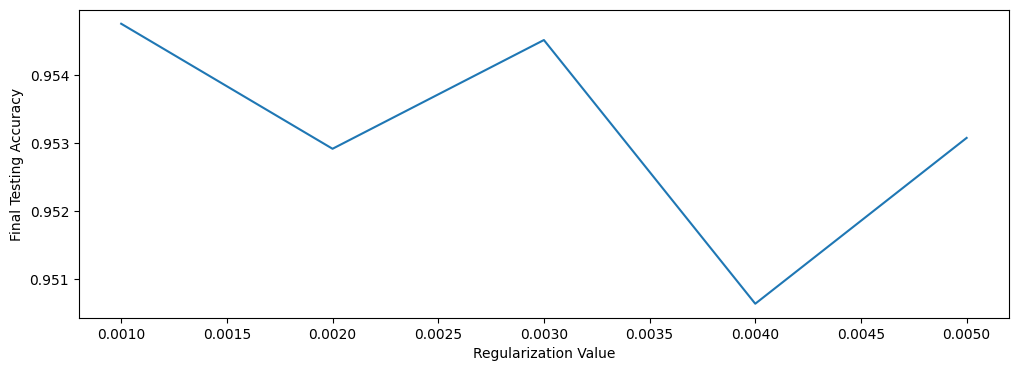

In [ ]:
mnist = torchvision.datasets.MNIST(root='.', download=True, transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000)),
                                        batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist, np.arange(5000, 10000)),
                                        batch_size=1000, shuffle=True)



final_testing_accuracy = []
drop_rates = np.linspace(0.001, 0.005, 5)

for r in drop_rates:
    total_accuracy = 0
    for j in range(5):
        network = Net(r, r)
        optimizer = optim.SGD(network.parameters(), lr=0.1, momentum=0.5)
        accuracy_train = []
        accuracy_test = []
        for i in range(5):
            continue_training()

        total_accuracy += accuracy_test[-1]
    final_testing_accuracy.append(total_accuracy / 5)


plt.figure(figsize=(12,4))
plt.plot(drop_rates, final_testing_accuracy)
plt.xlabel('Regularization Value')
plt.ylabel('Final Testing Accuracy')
plt.show()